# Do Wealthier Countries Provide Better Education?

### Scrape Data from the UN

In [2]:
#extracting data from: http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm

from bs4 import BeautifulSoup
import requests

url = "http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm"
r = requests.get(url)

soup = BeautifulSoup(r.content)

In [ ]:
#items we care about are at index 6
counter = 0
for row in soup('table'):
    print(counter)
    print(row)
    print
    counter += 1

In [181]:
#all the lines with relevant info (besides country name) have 'align' in them
soup('table')[6].find_all('tr')[8]

<tr class="tcont">
<td height="19">Afghanistan</td>
<td align="right" height="19">2004</td>
<td height="19"> </td>
<td height="19">a</td>
<td align="right" height="19" width="71">8</td>
<td width="6"></td>
<td height="19" width="51"></td>
<td align="right" height="19" width="72">11</td>
<td width="6"></td>
<td height="19" width="53"></td>
<td align="right" height="19" width="64">5</td>
<td height="19" width="59"></td>
</tr>

In [4]:
#this seems like a very kludgy way to do this - better way?

countries = []
values = {"year": [], "total": [], "men": [], "women": []}

all_rows = soup('table')[6].find_all('tr')

for row in all_rows[8:-11]:
    row_vals = row.contents

    countries.append(row_vals[1].get_text())
    country_vals = [row_vals[i].get_text() for i in range(len(row_vals)) if "align" in str(row_vals[i])]

    values["year"].append(int(country_vals[0]))
    values["total"].append(int(country_vals[1]))
    values["men"].append(int(country_vals[2]))
    values["women"].append(int(country_vals[3]))


In [25]:
#store data in a sqlite db
import sqlite3 as lite

con = lite.connect('education.db')
cur = con.cursor()

with con:
    cur.execute('''CREATE TABLE school_life
               (country TEXT,
                year INT,
                total INT,
                men INt,
                women INT)
                ''')
    
    ins_stmnt = """INSERT INTO school_life
                (country, year, total, men, women)
                VALUES (?, ?, ?, ?, ?)
                """

    for i, country in enumerate(countries):
        cur.execute(ins_stmnt,
                    (country,
                     values['year'][i],
                     values['total'][i],
                     values['men'][i],
                     values['women'][i]))

con.close()

### Profiling the Data

In [6]:
import pandas as pd
import sqlite3 as lite
con = lite.connect('education.db')
df = pd.read_sql_query("SELECT * FROM school_life ORDER BY country", con, index_col="country")
print df.head()
print df.tail()
print
print df.info()
print
print df.describe()

             year  total  men  women
country                             
Afghanistan  2004      8   11      5
Albania      2004     11   11     11
Algeria      2005     13   13     13
Andorra      2008     11   11     12
Anguilla     2008     11   11     11
                                    year  total  men  women
country                                                    
Venezuela (Bolivarian Republic of)  2008     14   13     15
Viet Nam                            2001     10   11     10
Yemen                               2005      9   11      7
Zambia                              2000      7    8      7
Zimbabwe                            2003      9    9      9

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, Afghanistan to Zimbabwe
Data columns (total 4 columns):
year     183 non-null int64
total    183 non-null int64
men      183 non-null int64
women    183 non-null int64
dtypes: int64(4)
memory usage: 7.1+ KB
None

              year       total         men       

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f07992860d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f07991f1d90>]], dtype=object)

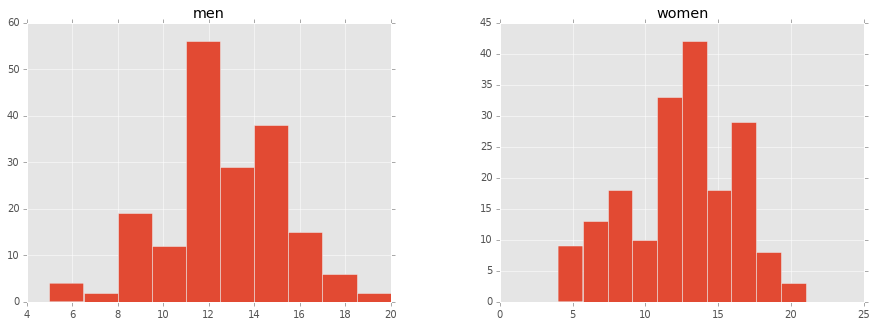

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

df[["men", "women"]].hist(figsize=(15,5))

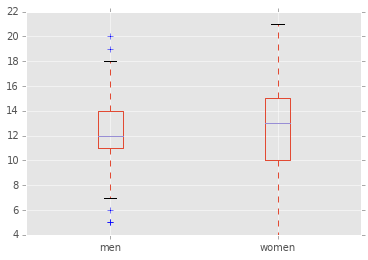

In [29]:
df[["men", "women"]].boxplot(return_type='axes')

In [9]:
print df["men"].mean()
print df['women'].mean()
print df["men"].median()
print df['women'].median()

12.393442623
12.5136612022
12.0
13.0


Based on both distributions being relatively normal, either mean or median seems appropriate here (which is reinforced by the values for mean and median being relatively similar). The male distribution has a few outliers at both the high and low ends

### Comopare GDP to Educational Attainment

In [11]:
import csv

con = lite.connect('gdp.db')
cur = con.cursor()


with open('ny.gdp.mktp.cd_Indicator_en_csv_v2.csv','rU') as inputFile:
    next(inputFile) # skip the first two     lines
    next(inputFile)
    header = next(inputFile) # is this supposed to be the column headers? This just has the "last updated" date in it
    next(inputFile) # skip empty line
    inputReader = csv.reader(inputFile)
    columns = next(inputReader)[43:-5] #this is the line with the actual column headers in it
    columns = ["country_name"] + ["_" + year for year in columns] # can't have number for column header, so at "_"; alsp, prepend country_name header
    inputs = ["country_name TEXT"] + [column + " NUMERIC" for column in columns[1:]]
    
    with con:
        cur.execute("CREATE TABLE gdp " + "(" + ", ".join(inputs) + ")")

        for line in inputReader:
            country = line[0]
            gdp_vals = line[43:-5]

            cur.execute("INSERT INTO gdp " + "(" + ", ".join(columns) + ") " +
                        'VALUES ("' + country + '","' + '","'.join(gdp_vals) + '");')



In [12]:
gdp_df = pd.read_sql_query("SELECT * FROM gdp ORDER BY country_name", con, index_col = "country_name")
gdp_df.head()

,_1999,_2000,_2001,_2002,_2003,_2004,_2005,_2006,_2007,_2008,_2009,_2010
country_name,,,,,,,,,,,,
Afghanistan,,,2.461666e+09,4.128818e+09,4.583649e+09,5.285462e+09,6.275076e+09,7.057598e+09,9.843842e+09,1.019053e+10,1.248694e+10,1.59368e+10
Albania,3.434402e+09,3.686649e+09,4.09102e+09,4.449373e+09,5.652325e+09,7.464447e+09,8.376668e+09,9.132558e+09,1.070101e+10,1.288135e+10,1.204421e+10,1.192696e+10
Algeria,4.864061e+10,5.479006e+10,5.474472e+10,5.676029e+10,6.786383e+10,8.5325e+10,1.031982e+11,1.170273e+11,1.349771e+11,1.710007e+11,1.37211e+11,1.612073e+11
American Samoa,,,,,,,,,,,,
Andorra,1.23984e+09,1.401694e+09,1.484005e+09,1.717564e+09,2.373836e+09,2.916913e+09,3.248135e+09,3.536452e+09,4.010785e+09,4.001349e+09,3.649863e+09,3.346317e+09


### Looking for relationship between GDP and school life expectancy

In [13]:
#get list of countries for which we have both data on GDP and life expectancy
ed_country_list = df.index.values.tolist()
gdp_country_list = gdp_df[gdp_df != ""].dropna().index.values.tolist()
country_list = list(set(ed_country_list).intersection(gdp_country_list))


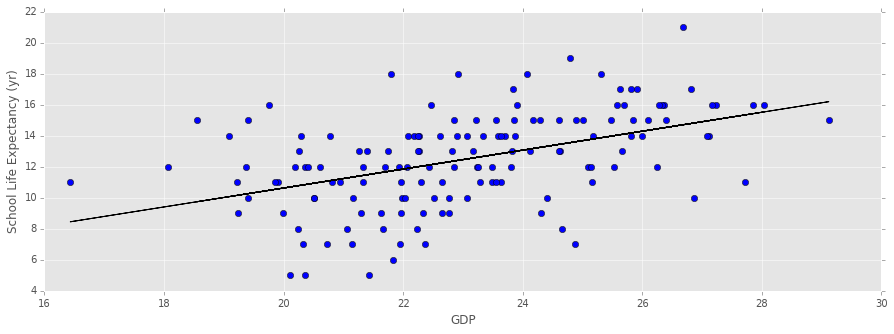

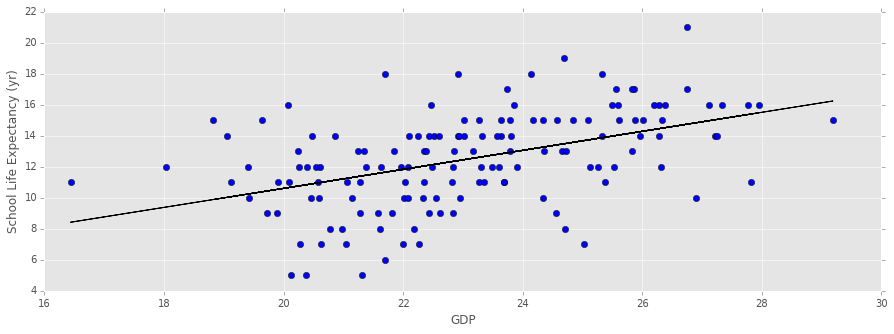

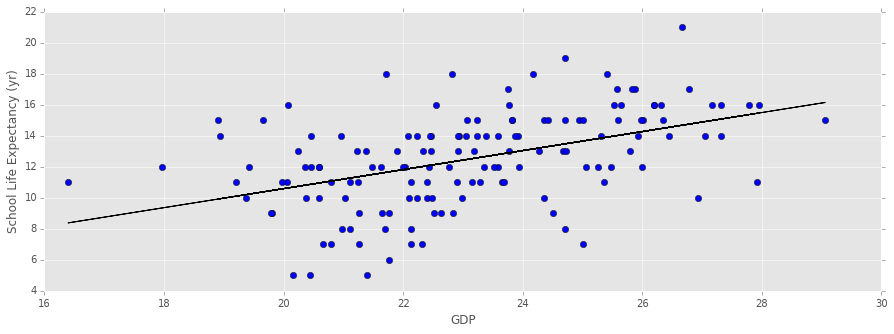

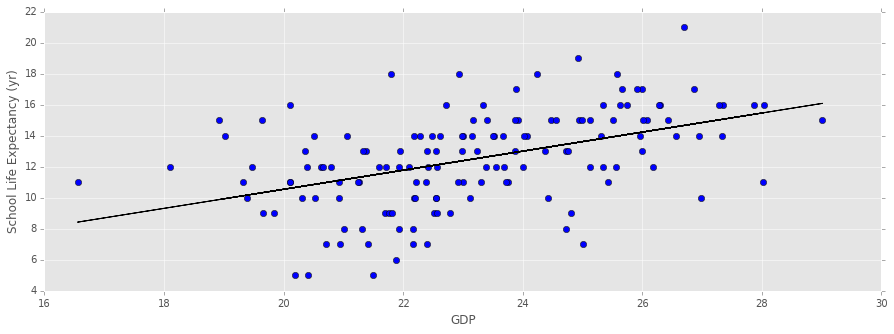

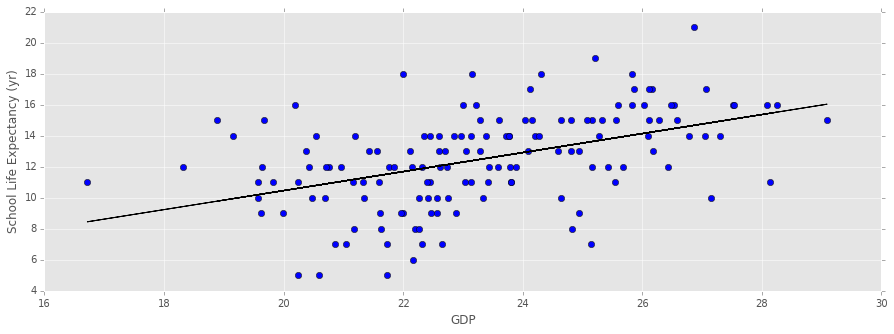

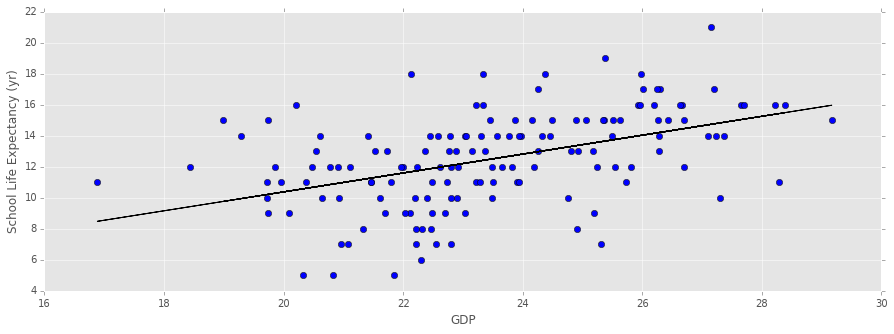

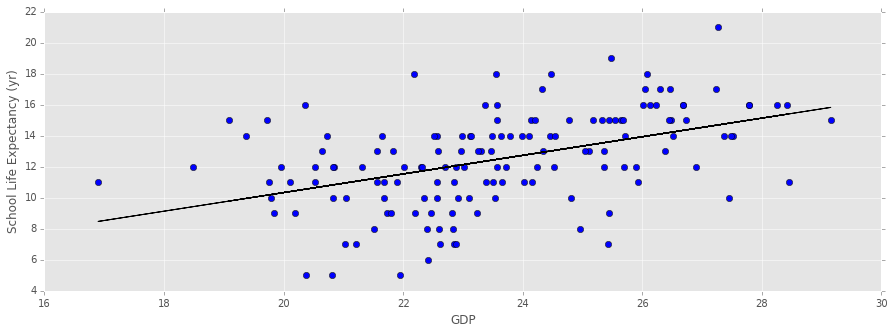

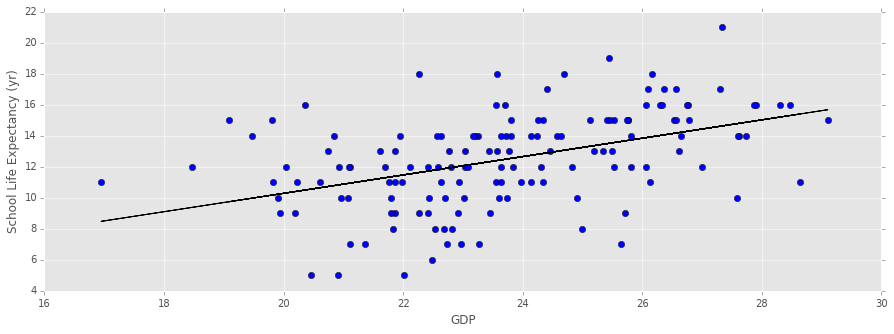

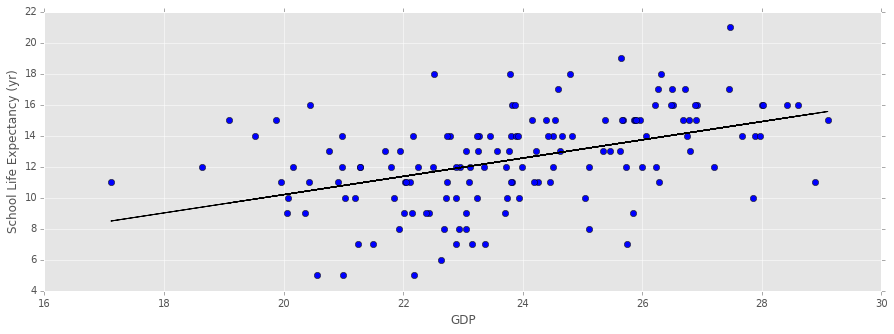

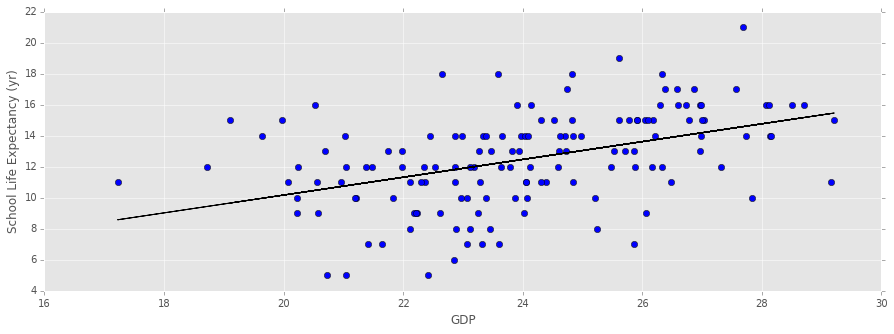

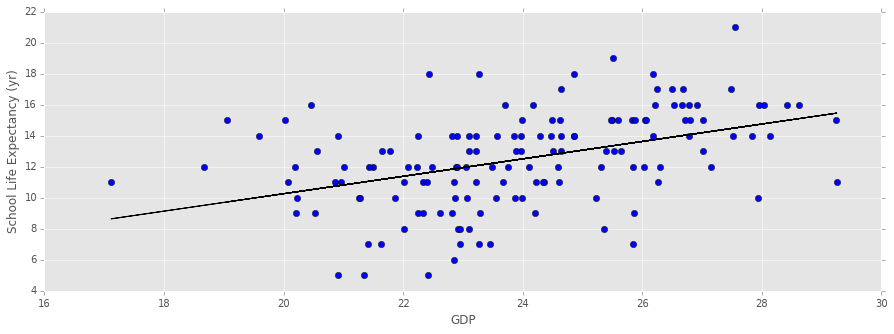

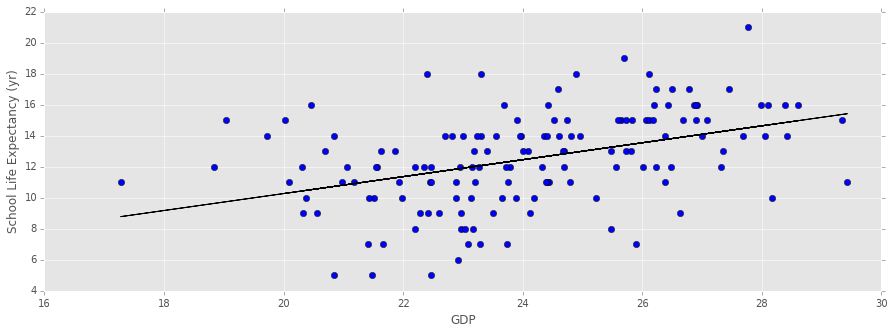

In [39]:
import numpy as np

years = gdp_df.columns
for year in years:
    y = df.ix[country_list]['total']
    x = np.log(gdp_df.ix[country_list][year], dtype='float64')
    
    fit = np.polyfit(x, y, 1)
    fit_func = np.poly1d(fit)
    plt.figure(figsize=(15,5))
    #plt.scatter(x, y)
    plt.plot(x, y, "bo", x, fit_func(x), "k")
    plt.xlabel("GDP")
    plt.ylabel("School Life Expectancy (yr)")

Unsuprisingly, there appears to be a positive correlation between country GDP and school life expectancy 

All the plots above look more or less the same, partly because we only have school life expectancy from one time point. Most of the early years that we have school life expectancy for have only a few data points (see below). For 2008 we have a good number of data points, though. Let's look at that year specifically then

In [60]:
df["year"].value_counts()

2008    73
2009    33
2007    15
2006    13
2005    12
2004    10
2000     7
2001     6
2003     5
2002     4
2010     3
1999     2
dtype: int64

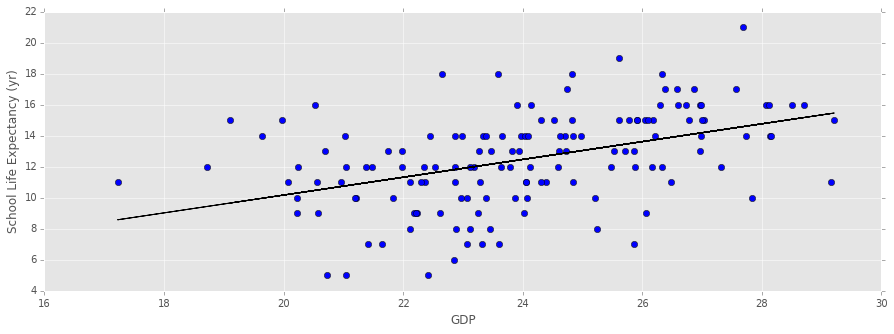

In [59]:
ed_2008_list = df[df["year"] == 2008].index.values.tolist()
country_list_08 = list(set(ed_2008_list).intersection(gdp_country_list))
y = df.ix[country_list]['total']
x = np.log(gdp_df.ix[country_list]["_2008"], dtype='float64')

fit = np.polyfit(x, y, 1)
fit_func = np.poly1d(fit)
plt.figure(figsize=(15,5))
plt.plot(x, y, "bo", x, fit_func(x), "k")
plt.xlabel("GDP")
plt.ylabel("School Life Expectancy (yr)")

We still see the same relationship, which again is expected

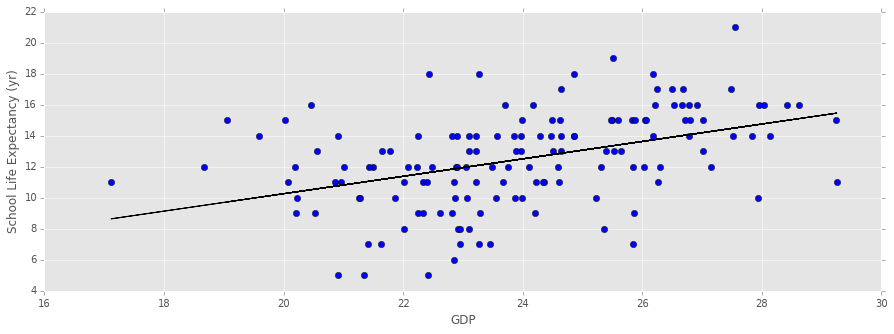

In [61]:
ed_2009_list = df[df["year"] == 2009].index.values.tolist()
country_list_09 = list(set(ed_2009_list).intersection(gdp_country_list))
y = df.ix[country_list]['total']
x = np.log(gdp_df.ix[country_list]["_2009"], dtype='float64')

fit = np.polyfit(x, y, 1)
fit_func = np.poly1d(fit)
plt.figure(figsize=(15,5))
plt.plot(x, y, "bo", x, fit_func(x), "k")
plt.xlabel("GDP")
plt.ylabel("School Life Expectancy (yr)")

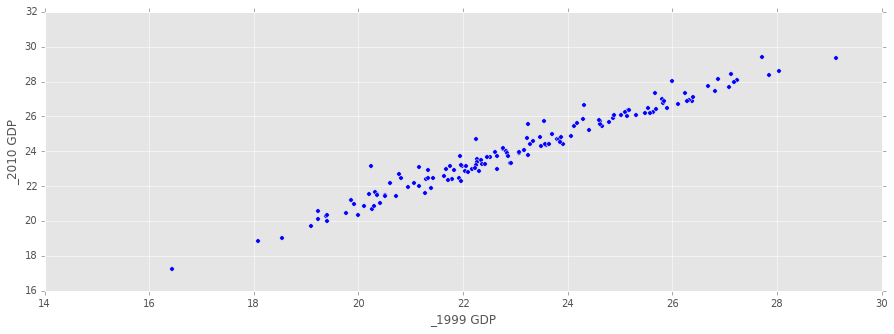

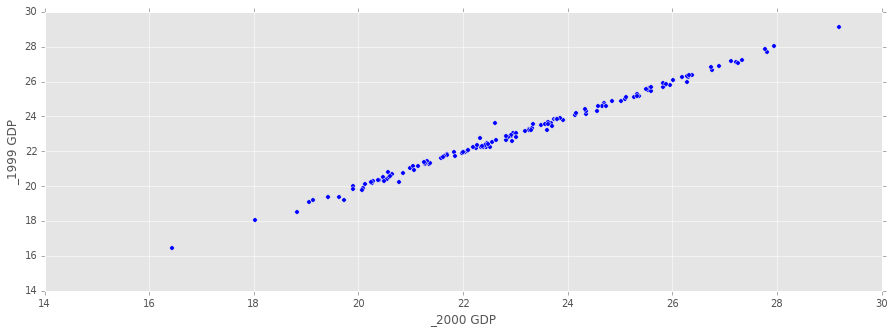

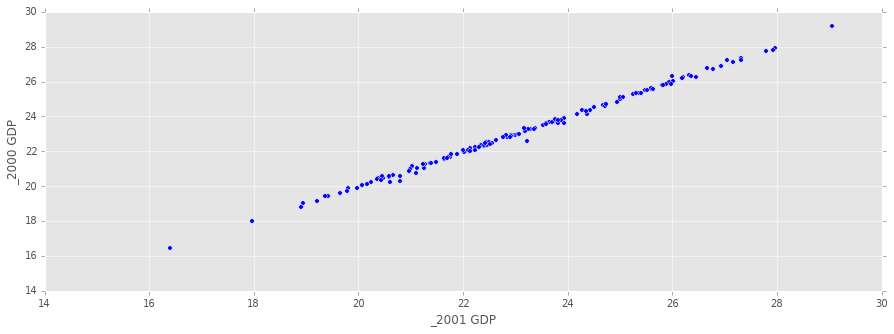

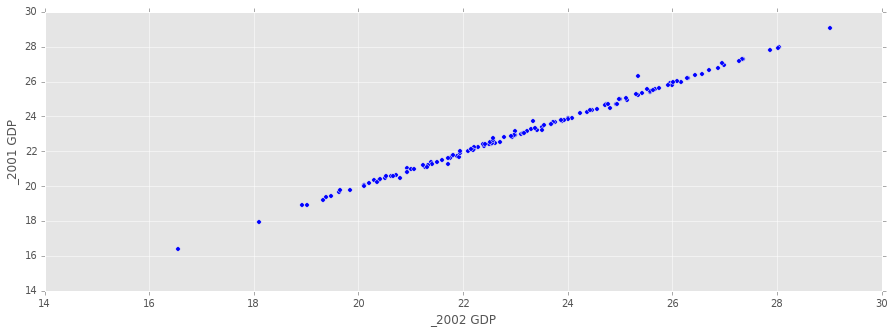

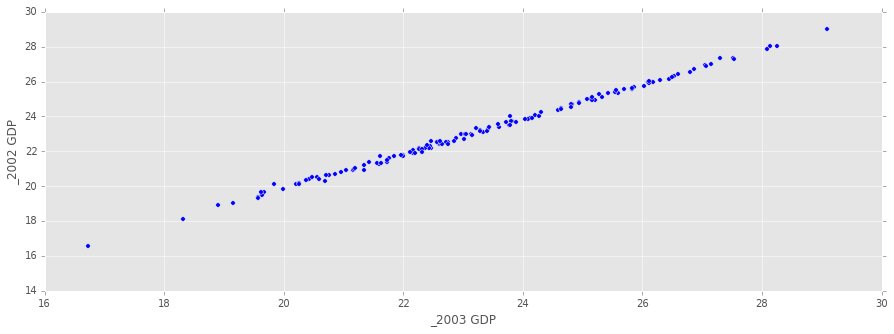

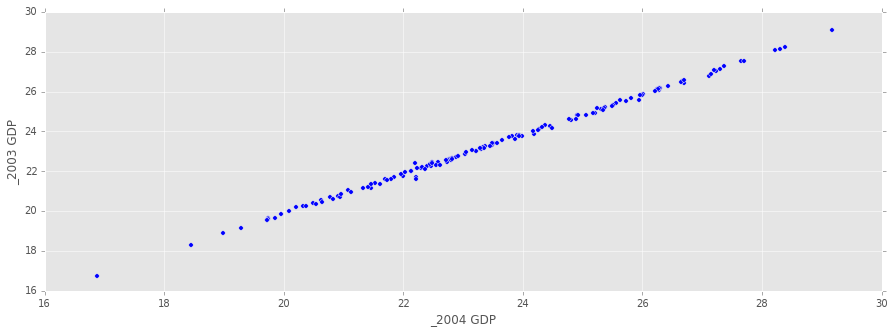

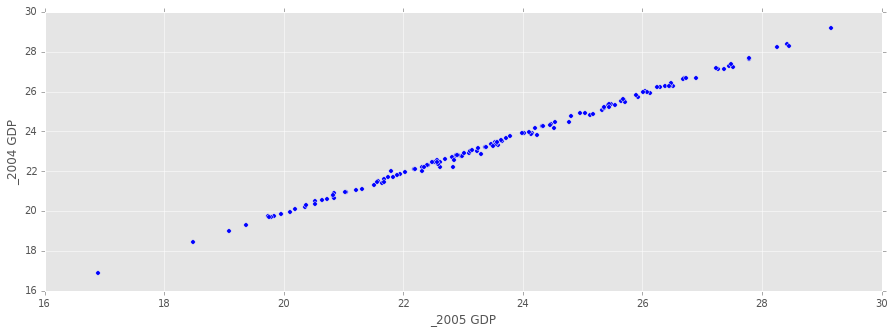

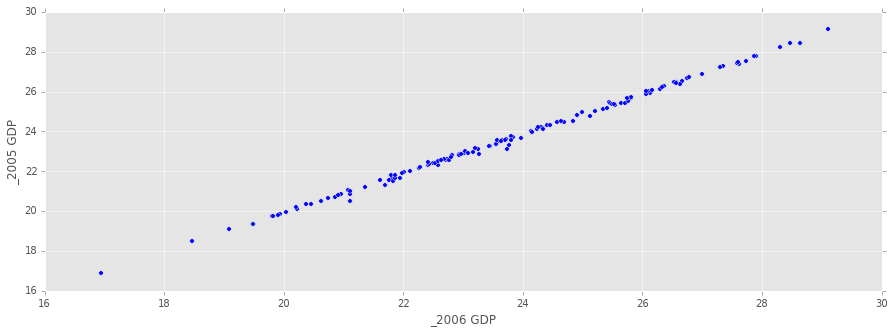

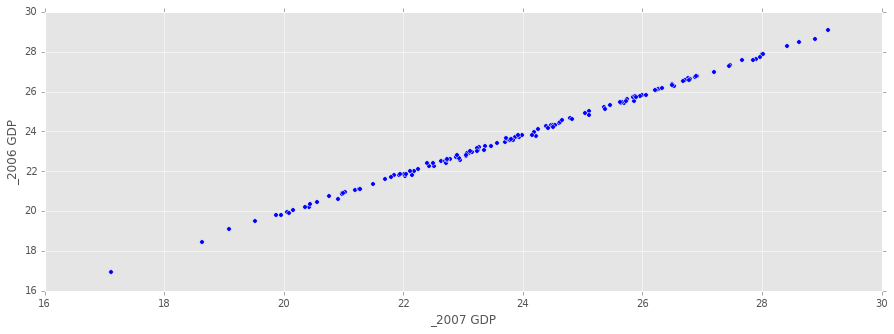

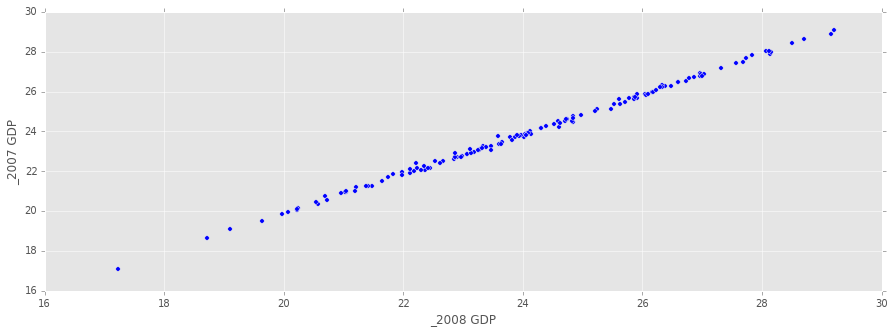

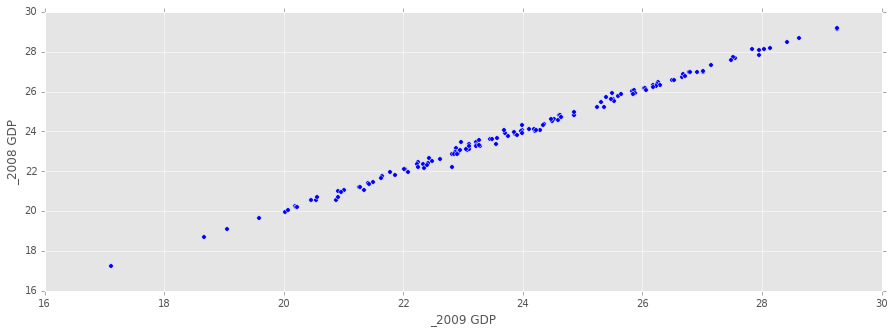

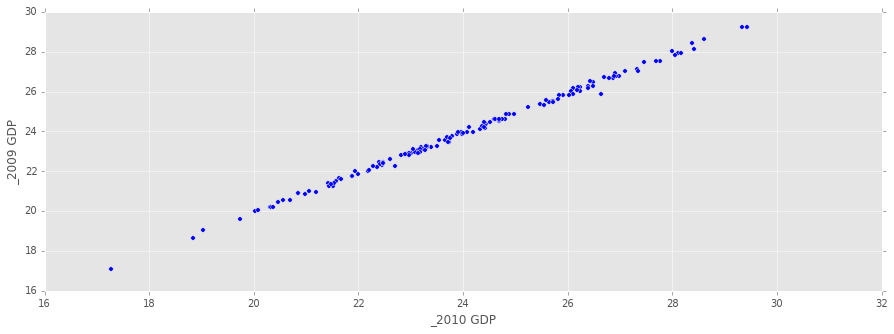

In [51]:
for i, year in enumerate(years):
    try:
        x = np.log(gdp_df.ix[country_list][year], dtype="float64")
        y = np.log(gdp_df.ix[country_list][years[i-1]], dtype="float64")

        plt.figure(figsize=(15,5))
        plt.scatter(x, y)
        plt.ylabel(years[i-1] + " GDP")
        plt.xlabel(year + " GDP")
    except:
        continue